## Pytorchの基本的な書き方

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading data
train_dataset = torchvision.datasets.CIFAR10(root="/deep_takaya/self_study/deep_learning/data", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(root="/deep_takaya/self_study/deep_learning/data", train=False, transform=transforms.ToTensor(), download=True)
image, label = train_dataset[0]

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Difinition of Dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [4]:
# Difinition of Network
num_classes = 10

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(32*32 * 3, 600)
        self.fc2 = nn.Linear(600, 600)
        self.fc3 = nn.Linear(600, num_classes)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return F.relu(self.fc3(x))

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

net = MLPNet().to(device)

In [5]:
# loss function and optimization function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [6]:
# training
num_epochs = 50

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train===========================
    net.train()
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(images)
        
        loss = criterion(outputs, labels)
        
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        
        loss.backward()
        
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val===============================
    net.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
        
        print("Epoch [{}/{}], Loss: {loss:.4f}, valloss: {val_loss:.4f}, val_acc: {val_acc:.4f}".format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
        
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

Epoch [1/50], Loss: 0.0305, valloss: 0.0274, val_acc: 0.3803
Epoch [2/50], Loss: 0.0275, valloss: 0.0261, val_acc: 0.4024
Epoch [3/50], Loss: 0.0264, valloss: 0.0251, val_acc: 0.4196
Epoch [4/50], Loss: 0.0257, valloss: 0.0247, val_acc: 0.4387
Epoch [5/50], Loss: 0.0252, valloss: 0.0242, val_acc: 0.4541
Epoch [6/50], Loss: 0.0246, valloss: 0.0240, val_acc: 0.4526
Epoch [7/50], Loss: 0.0244, valloss: 0.0239, val_acc: 0.4523
Epoch [8/50], Loss: 0.0240, valloss: 0.0237, val_acc: 0.4584
Epoch [9/50], Loss: 0.0237, valloss: 0.0233, val_acc: 0.4753
Epoch [10/50], Loss: 0.0235, valloss: 0.0234, val_acc: 0.4710
Epoch [11/50], Loss: 0.0232, valloss: 0.0223, val_acc: 0.4951
Epoch [12/50], Loss: 0.0228, valloss: 0.0224, val_acc: 0.4886
Epoch [13/50], Loss: 0.0227, valloss: 0.0224, val_acc: 0.4877
Epoch [14/50], Loss: 0.0226, valloss: 0.0221, val_acc: 0.5035
Epoch [15/50], Loss: 0.0224, valloss: 0.0224, val_acc: 0.4986
Epoch [16/50], Loss: 0.0221, valloss: 0.0217, val_acc: 0.5087
Epoch [17/50], Lo

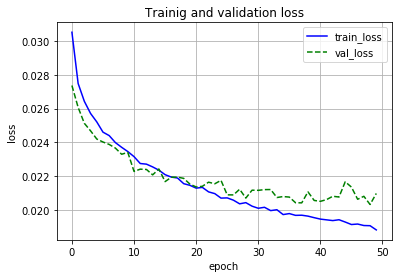

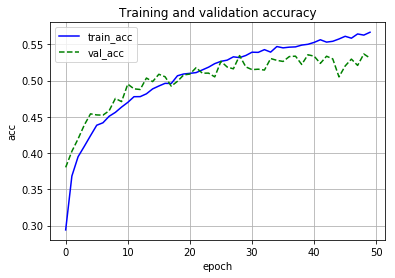

In [7]:
# plot results
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color="blue", linestyle="-", label="train_loss")
plt.plot(range(num_epochs), val_loss_list, color="green", linestyle="--", label="val_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Trainig and validation loss")
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color="blue", linestyle="-", label="train_acc")
plt.plot(range(num_epochs), val_acc_list, color="green", linestyle="--", label="val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.title("Training and validation accuracy")
plt.grid()

In [8]:
# save and load trained network
torch.save(net.state_dict(), "net.ckpt")

net2 = MLPNet().to(device)
net2.load_state_dict(torch.load("net.ckpt"))

In [11]:
# Inference
net2.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:
        images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)
        
        outputs = net2(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print("accracy; {} %".format(100 * test_acc / total))

accracy; 53.1 %


An_introduction_to_tensorflow  data		net.ckpt	  rnn
chainer			       dl_from_scratch	pytorch_practice
chainer_practice	       gan		r_cnn
